#**스마트폰 센서 데이터 기반 모션 분류**
# 단계2 : 기본 모델링


## 0.미션

* 데이터 전처리
    * 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리 수행
* 다양한 알고리즘으로 분류 모델 생성
    * 최소 4개 이상의 알고리즘을 적용하여 모델링 수행
    * 성능 비교
    * 각 모델의 성능을 저장하는 별도 데이터 프레임을 만들고 비교
* 옵션 : 다음 사항은 선택사항입니다. 시간이 허용하는 범위 내에서 수행하세요.
    * 상위 N개 변수를 선정하여 모델링 및 성능 비교
        * 모델링에 항상 모든 변수가 필요한 것은 아닙니다.
        * 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교하세요.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것입니다.

## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import *

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

* 함수 생성

In [6]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

In [30]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err')
    plt.plot(history['val_loss'], label='val_err')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용
* 세부 요구사항
    - 전체 데이터 'data01_train.csv' 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - 데이터프레임에 대한 기본 정보를 확인합니다.( .head(), .shape 등)

#### 1) 데이터 로딩

In [7]:
data = pd.read_csv('/content/drive/MyDrive/3차 미프/data01_train.csv')
test = pd.read_csv('/content/drive/MyDrive/3차 미프/data01_test.csv')
features = pd.read_csv('/content/drive/MyDrive/3차 미프/features_importance.csv',index_col=False)


data.drop('subject', axis=1, inplace=True)
test.drop('subject', axis=1, inplace=True)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### 2) 기본 정보 조회

## **2. 데이터 전처리**

* 가변수화, 데이터 분할, NaN 확인 및 조치, 스케일링 등 필요한 전처리를 수행한다.


### (1) 데이터 분할1 : x, y

* 세부 요구사항
    - x, y로 분할합니다.

In [10]:
target = 'Activity'
x = data.drop(target, axis = 1)
y = data.loc[:, target]

In [11]:
scaler = MinMaxScaler()
x_s = scaler.fit_transform(x)

In [12]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .2, random_state = 2023)
x_train_s, x_val_s, y_train_s, y_val_s = train_test_split(x_s, y, test_size = .2, random_state = 2023)

### (2) 스케일링(필요시)


* 세부 요구사항
    - 스케일링을 필요로 하는 알고리즘 사용을 위해서 코드 수행
    - min-max 방식 혹은 standard 방식 중 한가지 사용.

In [13]:
# 정수 인코딩
y_train_i = y_train.map({'LAYING':0,'STANDING':1,'SITTING':2,'WALKING':3,'WALKING_UPSTAIRS':4,'WALKING_DOWNSTAIRS':5})
#y_train.head()

In [14]:
y_val_i = y_val.map({'LAYING':0,'STANDING':1,'SITTING':2,'WALKING':3,'WALKING_UPSTAIRS':4,'WALKING_DOWNSTAIRS':5})

In [15]:
features['importance'] = features[['importance_activity', 'importance_dynamic', 'importance_standing', 'importance_sitting', 'importance_laying', 'importance_walking', 'importance_walking_up', 'importance_walking_down']].sum(axis=1)

### (3) 데이터분할2 : train, validation

* 세부 요구사항
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

## **3. 기본 모델링**



* 세부 요구사항
    - 최소 4개 이상의 알고리즘을 적용하여 모델링을 수행한다.
    - 각 알고리즘별로 전체 변수로 모델링, 상위 N개 변수를 선택하여 모델링을 수행하고 성능 비교를 한다.
    - (옵션) 알고리즘 중 1~2개에 대해서, 변수 중요도 상위 N개를 선정하여 모델링하고 타 모델과 성능을 비교.
        * 상위 N개를 선택하는 방법은, 변수를 하나씩 늘려가며 모델링 및 성능 검증을 수행하여 적절한 지점을 찾는 것이다.

### (1) 알고리즘1 :

In [17]:
# RF

m1_1 = RandomForestClassifier()

m1_1.fit(x_train, y_train)
p1_1 = m1_1.predict(x_val)

In [18]:
print('accuracy :',accuracy_score(y_val, p1_1))
print('='*60)
print(confusion_matrix(y_val, p1_1))
print('='*60)
print(classification_report(y_val, p1_1))

accuracy : 0.9770603228547153
[[230   0   0   0   0   0]
 [  0 197  12   0   0   0]
 [  0   5 213   0   0   0]
 [  0   0   0 175   4   1]
 [  0   0   0   2 161   2]
 [  0   0   0   0   1 174]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.98      0.94      0.96       209
          STANDING       0.95      0.98      0.96       218
           WALKING       0.99      0.97      0.98       180
WALKING_DOWNSTAIRS       0.97      0.98      0.97       165
  WALKING_UPSTAIRS       0.98      0.99      0.99       175

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



In [19]:
r = plot_feature_importance(m1_1.feature_importances_, list(x_train), True)

In [20]:
r.head()

,feature_name,feature_importance
0,tGravityAcc-min()-X,0.033868
1,tGravityAcc-min()-Y,0.028250
2,tGravityAcc-max()-Y,0.028157
3,tGravityAcc-mean()-Y,0.027927
4,tGravityAcc-max()-X,0.025116


In [22]:
# 변수 중요도 상위 100으로 모델링

In [23]:
feature100 = r.loc[:99, 'feature_name']

x_train100 = x_train[feature100]
x_val100 = x_val[feature100]

m1_2 = RandomForestClassifier()

m1_2.fit(x_train100, y_train)
p1_2 = m1_2.predict(x_val100)

print('accuracy :',accuracy_score(y_val, p1_2))
print('='*60)
print(confusion_matrix(y_val, p1_2))
print('='*60)
print(classification_report(y_val, p1_2))

accuracy : 0.9796091758708582
[[230   0   0   0   0   0]
 [  0 201   8   0   0   0]
 [  0   5 213   0   0   0]
 [  0   0   0 174   3   3]
 [  0   0   0   2 161   2]
 [  0   0   0   0   1 174]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.98      0.96      0.97       209
          STANDING       0.96      0.98      0.97       218
           WALKING       0.99      0.97      0.98       180
WALKING_DOWNSTAIRS       0.98      0.98      0.98       165
  WALKING_UPSTAIRS       0.97      0.99      0.98       175

          accuracy                           0.98      1177
         macro avg       0.98      0.98      0.98      1177
      weighted avg       0.98      0.98      0.98      1177



### (2) 알고리즘2 :

In [ ]:
#Logistic Regressin

In [24]:
m2_1 = LogisticRegression()

m2_1.fit(x_train, y_train)
p2_1 = m2_1.predict(x_val)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
print('accuracy :',accuracy_score(y_val, p2_1))
print('='*60)
print(confusion_matrix(y_val, p2_1))
print('='*60)
print(classification_report(y_val, p2_1))

accuracy : 0.9872557349192863
[[230   0   0   0   0   0]
 [  0 202   7   0   0   0]
 [  0   6 212   0   0   0]
 [  0   0   0 180   0   0]
 [  0   0   0   0 165   0]
 [  0   0   0   2   0 173]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.97      0.97      0.97       209
          STANDING       0.97      0.97      0.97       218
           WALKING       0.99      1.00      0.99       180
WALKING_DOWNSTAIRS       1.00      1.00      1.00       165
  WALKING_UPSTAIRS       1.00      0.99      0.99       175

          accuracy                           0.99      1177
         macro avg       0.99      0.99      0.99      1177
      weighted avg       0.99      0.99      0.99      1177



In [26]:
# 변수 중요도 상위 100으로 모델링

In [27]:
feature100 = r.loc[:99, 'feature_name']

x_train100 = x_train[feature100]
x_val100 = x_val[feature100]

In [28]:
m2_2 = LogisticRegression()

m2_2.fit(x_train100, y_train)
p2_2 = m2_2.predict(x_val100)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [29]:
print('accuracy :',accuracy_score(y_val, p2_2))
print('='*60)
print(confusion_matrix(y_val, p2_2))
print('='*60)
print(classification_report(y_val, p2_2))

accuracy : 0.9558198810535259
[[230   0   0   0   0   0]
 [  0 184  25   0   0   0]
 [  0  18 200   0   0   0]
 [  0   0   0 175   2   3]
 [  0   0   0   1 163   1]
 [  0   0   0   2   0 173]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       230
           SITTING       0.91      0.88      0.90       209
          STANDING       0.89      0.92      0.90       218
           WALKING       0.98      0.97      0.98       180
WALKING_DOWNSTAIRS       0.99      0.99      0.99       165
  WALKING_UPSTAIRS       0.98      0.99      0.98       175

          accuracy                           0.96      1177
         macro avg       0.96      0.96      0.96      1177
      weighted avg       0.96      0.96      0.96      1177



### (3) 알고리즘3 :

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                3570      
                                                                 
 dense_1 (Dense)             (None, 24)                1704      
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 6)                 78        
                                                                 
Total params: 5652 (22.08 KB)
Trainable params: 5652 (22.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.

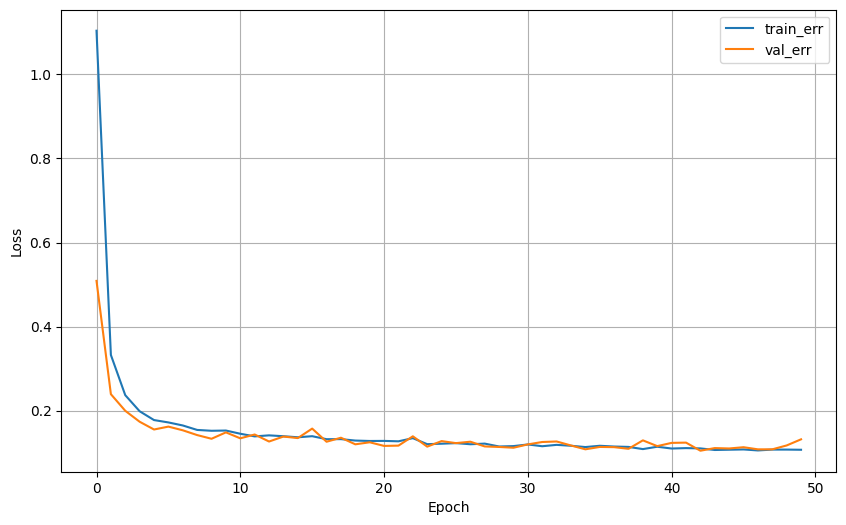

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                7070      
                                                                 
 dense_1 (Dense)             (None, 24)                1704      
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 6)                 78        
                                                                 
Total params: 9152 (35.75 KB)
Trainable params: 9152 (35.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.

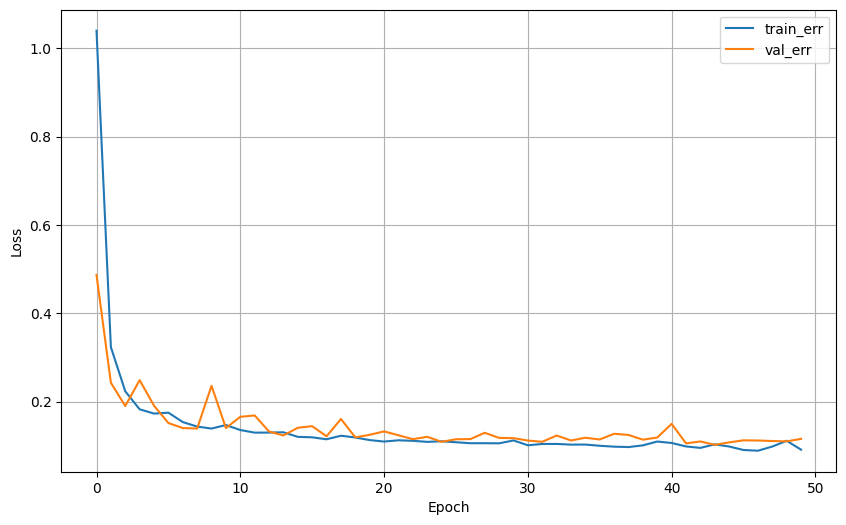

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                10570     
                                                                 
 dense_1 (Dense)             (None, 24)                1704      
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 6)                 78        
                                                                 
Total params: 12652 (49.42 KB)
Trainable params: 12652 (49.42 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
37/37 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      

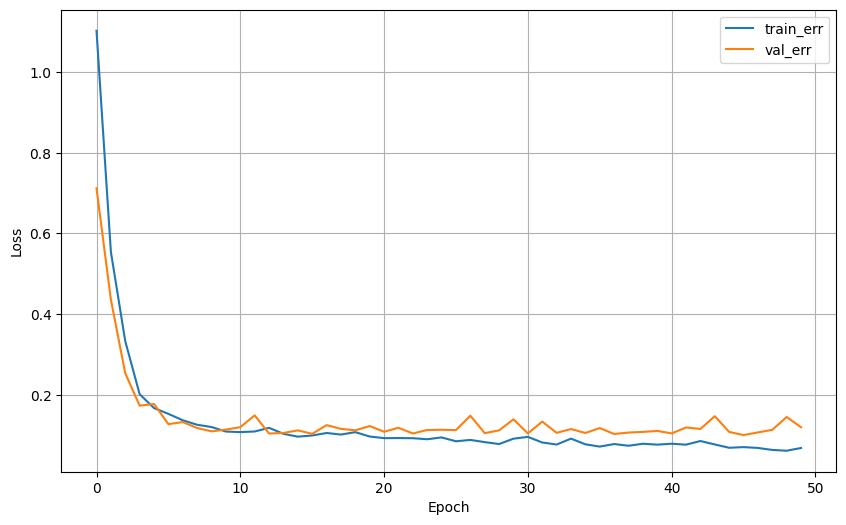

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                14070     
                                                                 
 dense_1 (Dense)             (None, 24)                1704      
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 6)                 78        
                                                                 
Total params: 16152 (63.09 KB)
Trainable params: 16152 (63.09 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      

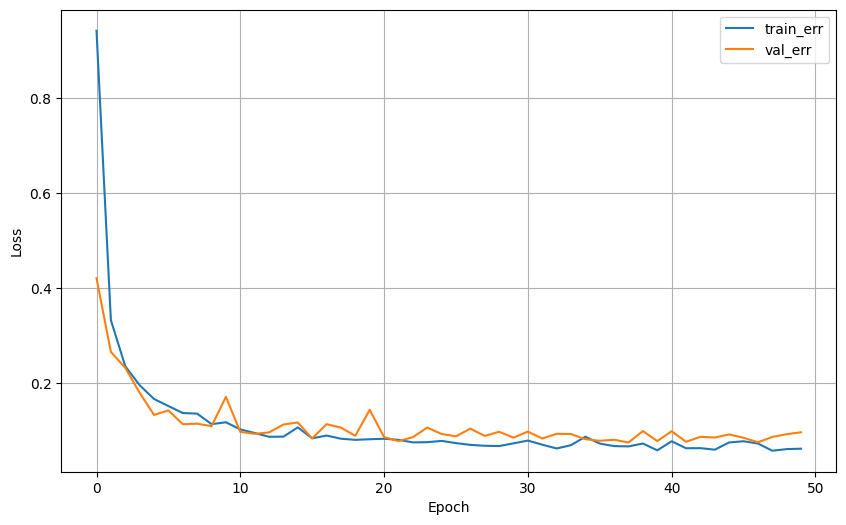

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                17570     
                                                                 
 dense_1 (Dense)             (None, 24)                1704      
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 6)                 78        
                                                                 
Total params: 19652 (76.77 KB)
Trainable params: 19652 (76.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      

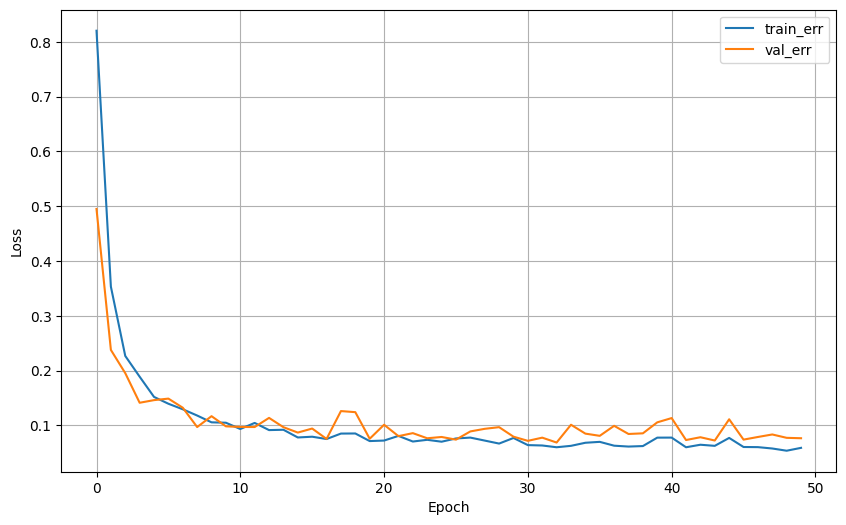

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                21070     
                                                                 
 dense_1 (Dense)             (None, 24)                1704      
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 6)                 78        
                                                                 
Total params: 23152 (90.44 KB)
Trainable params: 23152 (90.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      

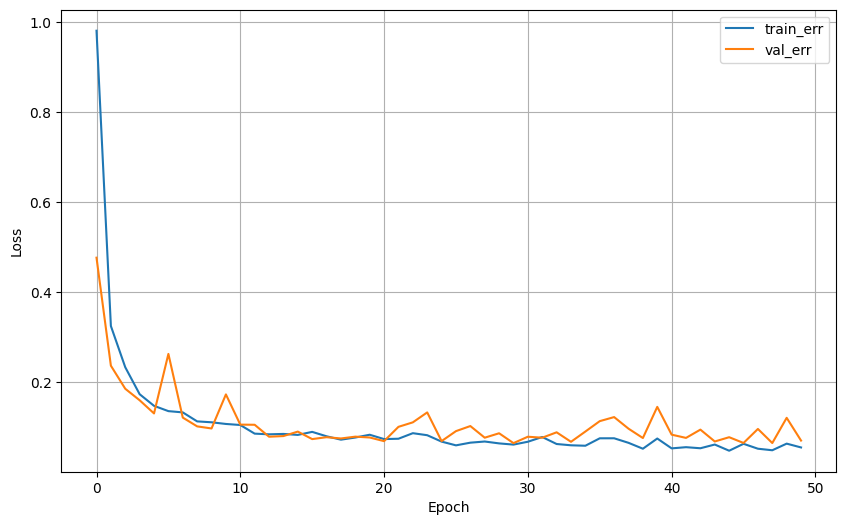

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                24570     
                                                                 
 dense_1 (Dense)             (None, 24)                1704      
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 6)                 78        
                                                                 
Total params: 26652 (104.11 KB)
Trainable params: 26652 (104.11 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
37/37 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00    

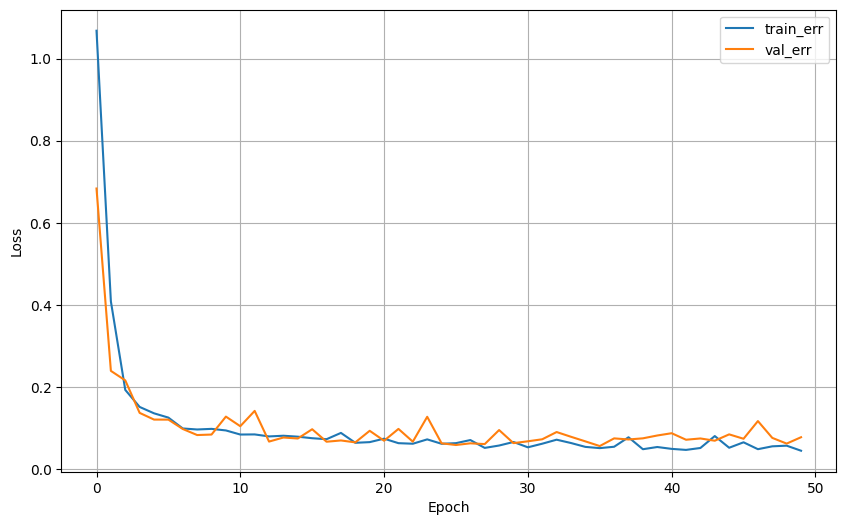

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                28070     
                                                                 
 dense_1 (Dense)             (None, 24)                1704      
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 6)                 78        
                                                                 
Total params: 30152 (117.78 KB)
Trainable params: 30152 (117.78 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00    

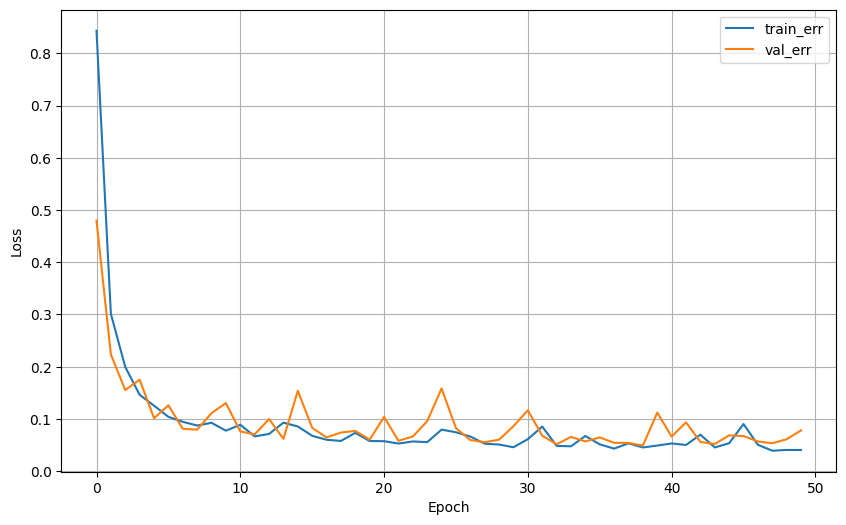

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                31570     
                                                                 
 dense_1 (Dense)             (None, 24)                1704      
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 6)                 78        
                                                                 
Total params: 33652 (131.45 KB)
Trainable params: 33652 (131.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
37/37 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00    

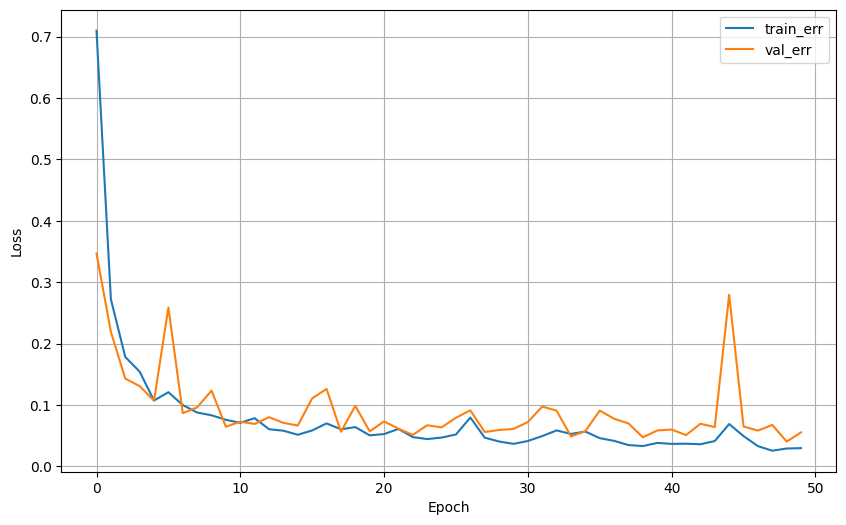

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 70)                35070     
                                                                 
 dense_1 (Dense)             (None, 24)                1704      
                                                                 
 dense_2 (Dense)             (None, 12)                300       
                                                                 
 dense_3 (Dense)             (None, 6)                 78        
                                                                 
Total params: 37152 (145.12 KB)
Trainable params: 37152 (145.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
37/37 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       1.00      1.00    

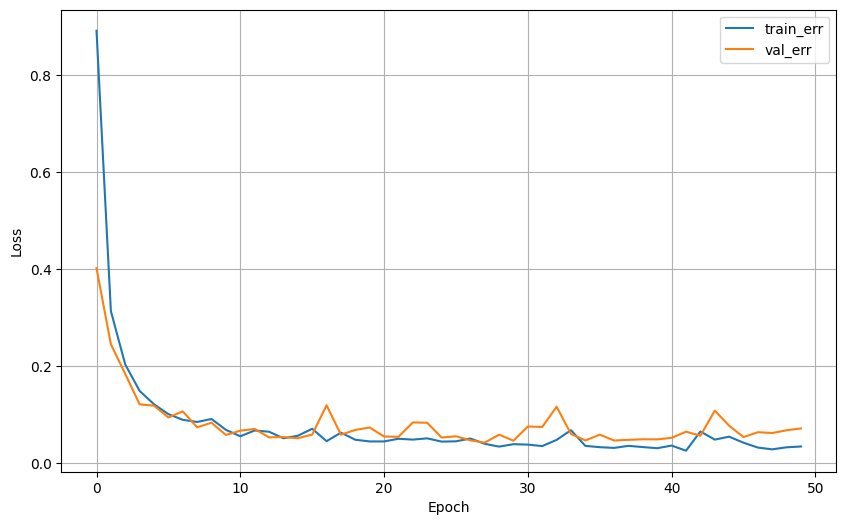

In [32]:
# 딥러닝

def modeling_test3(sp) :
    columns = features.sort_values(by = 'importance')['feature_name'][-sp:]

    x_train_n = x_train.loc[:, columns]
    x_test_n = x_val.loc[:, columns]

    clear_session()

    # 레이어 수 정한 모델(현재는 임의)
    model = Sequential( [Dense(70, input_shape = (x_train_n.shape[1],), activation= 'relu'),
                      Dense(24, activation= 'relu'),
                      Dense(12, activation= 'relu'),
                      Dense(6, activation= 'softmax')] )
    print(model.summary())

    model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy')
    h = model.fit(x_train_n, y_train_i, epochs = 50, verbose = False,validation_split=0.2).history

    pred = model.predict(x_test_n)
    pred = pred.argmax(axis=1)
    print(classification_report(y_val_i, pred))
    dl_history_plot(h)

layers = list(range(50, 501, 50))
result = []
for l in layers :
  modeling_test3(l)
# sorted_df = data2.sort_values(by='importance_sum', ascending=False)

### (4) 알고리즘4 :

In [ ]:
# 하이퍼 파라미터 튜닝

In [33]:
# 딕셔너리 형태로 관심있는 매개변수의 그리드 설정하기
param_grid = {'C': [0.01, 1, 100],
             'gamma': [0.0001, 0.001, 0.1, 1],
              'kernel': ['linear', 'rbf'] }

#생성
# refit=True 가 default 임. True이면 가장 좋은 파라미터 설정으로 재학습시킴.
model_svc = SVC()
m3_3= GridSearchCV (model_svc, param_grid, return_train_score=True) #cross-validation 옵션 추가? cv=5

#학습
# train data로 param_grid의 하이퍼 파라미터들을 순차적으로 학습/평가 .
m3_3.fit(x_train, y_train)

#결과
# GridSearchCV 결과 추출하여 DataFrame으로 변환
scores_df = pd.DataFrame(m3_3.cv_results_)

In [34]:
print('최적파라미터:', m3_3.best_params_)
print('='*60)
print('최고성능:', m3_3.best_score_)
print('='*60)

최적파라미터: {'C': 1, 'gamma': 0.0001, 'kernel': 'linear'}
최고성능: 0.98448187758609
